In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor


from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.nn.functional as F

import numpy as np


import matplotlib.pyplot as plt

from PIL import Image

import os
import glob


from MyDataLoader import ShuffleDataLoader
from FileReader import get_picture_tensors
from MyModels import SimpleCNN, CatNet
from ModelEvaluation import eval_model


In [2]:
# data params
n_classes = 50

required_train_imgs = 10
required_test_imgs = 1

In [3]:
root_dir = "dataset_chat_eliot_downscale"
# root_dir = "dataset_chat_downscale_no_background"
(train_images, val_images, test_images, 
 train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes, 
                                                              required_train_imgs=required_train_imgs, 
                                                              required_test_imgs=required_test_imgs)

Chargement de dataset_chat_eliot_downscale\0001  ->  12/17 images
Chargement de dataset_chat_eliot_downscale\0002  ->  12/20 images
Chargement de dataset_chat_eliot_downscale\0003  ->  12/15 images
Chargement de dataset_chat_eliot_downscale\0004  ->  12/56 images
Chargement de dataset_chat_eliot_downscale\0005  ->  12/41 images
Chargement de dataset_chat_eliot_downscale\0006  ->  12/40 images
Chargement de dataset_chat_eliot_downscale\0007  ->  12/41 images
Chargement de dataset_chat_eliot_downscale\0008  ->  12/18 images
Chargement de dataset_chat_eliot_downscale\0009  ->  12/13 images
Chargement de dataset_chat_eliot_downscale\0010  ->  12/36 images
Chargement de dataset_chat_eliot_downscale\0011  ->  12/26 images
Chargement de dataset_chat_eliot_downscale\0012  ->  12/17 images
Chargement de dataset_chat_eliot_downscale\0014  ->  12/16 images
Chargement de dataset_chat_eliot_downscale\0015  ->  12/53 images
Chargement de dataset_chat_eliot_downscale\0016  ->  12/32 images
Chargement

In [4]:
# params du modèle, essayer avec gridsearch (idéalement Randomized pour ne pas prendre énormément de temps), avec une bonne machine durant la nuit ou qqch
# faudrait idéalement logger les performances selon chaque combination de params pour s'amuser
# num_epochs = 6
num_epochs = 4
batch_size = 8
learning_rate = 1e-3


train_dataset = ShuffleDataLoader(train_images, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataset = ShuffleDataLoader(val_images, val_labels)


# model = SimpleCNN(n_classes)
# model = SimpleCNN(n_classes, pretrained = False, train_hidden_layer = True)
# model = SimpleCNN(n_classes, pretrained = True, train_hidden_layer = True)

model = CatNet(n_classes)

model.train()

criterion = nn.CrossEntropyLoss()
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = optim.Adam(params, lr = learning_rate)

# Gossage sur les params potentiel
# momentum = 0.5
# weight_decay = 1e-5 
# criterion = nn.CrossEntropyLoss(reduction = 'sum')
# criterion = nn.CrossEntropyLoss(reduction = 'none')
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(params, lr = learning_rate, weight_decay = weight_decay)
# optimizer = optim.SGD(params, lr = learning_rate, momentum = momentum)   

accuracy_at_each_epoch = []
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
print('Training and evaluation finished.')

Accuracy on validation dataset: 93.75%
Accuracy on validation dataset: 95.83%
Accuracy on validation dataset: 97.92%
Accuracy on validation dataset: 93.75%
Training and evaluation finished.


In [5]:
# # Décommenter pour rouler d'autre épochs supplémentaires sans repartir de 0
# for epoch in range(num_epochs):
#     for images, labels in train_dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     accuracy_at_each_epoch.append(eval_model(model, val_dataset))
    
# print('Training and evaluation finished.')

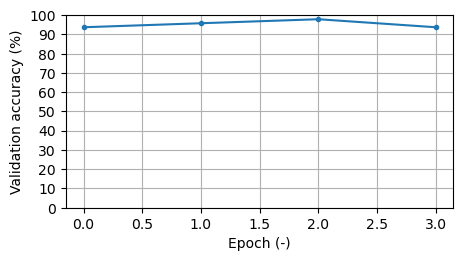

In [6]:
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

ax.set_xlabel('Epoch (-)')
ax.set_ylabel('Validation accuracy (%)')
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 110, 10))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.plot(accuracy_at_each_epoch, '.-')

plt.grid(True)


In [7]:
# # Pour loader des nouvelles données à tester
# # Problème avec les labels!

# # root_dir = "dataset_chat_downscale"
# root_dir = "dataset_chat_downscale_no_background"
# (train_images, val_images, test_images, 
#  train_labels, val_labels, test_labels) = get_picture_tensors(root_dir, n_classes=n_classes,
#                                                required_train_imgs=required_test_imgs,
#                                                required_test_imgs=required_test_imgs)

# # array of 10 zeros
# index = np.zeros(len(test_images))
# score = np.zeros(len(test_images))
# for i in range(len(test_images)-1, 0, -1):
#     test_images = test_images[:i]  # sa réduit la taille jusqu'à 0.. 
#     test_labels = test_labels[:i]
#     test_dataset = ShuffleDataLoader(test_images, test_labels)
#     # print(test_labels_i)
#     index[i] = i
#     score[i] = eval_model(model, test_dataset)

In [8]:
# plt.plot(index, score)
# plt.xlabel('Number of test images')
# plt.ylabel('Accuracy (%)')

    Classe : 45
Prédiction : 45


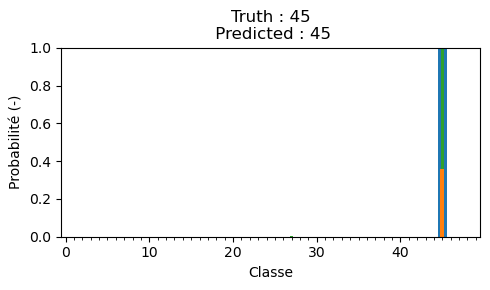

In [9]:
# Test individuel du model


index = 45

# index 21 = 0023
# index 21 = 0026

# import dataset_preprocessing
# dataset_preprocessing.show_images_as_grid(val_images[index])

model.eval()

with torch.no_grad():
    images = val_images[index]
    labels = val_labels[index]

    images = images.unsqueeze(0)
    outputs = model(images)

    sig_output = F.sigmoid(outputs).squeeze(0)

    _, predicted = torch.max(outputs.data, 1)


from matplotlib.ticker import MultipleLocator

x_axis = np.arange(0, n_classes, 1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.set_xlabel('Classe')
ax.set_ylabel('Probabilité (-)')
ax.set_xlim(0 - 0.5, n_classes - 0.5)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_title('Truth : ' + str(index) + '\n Predicted : ' + str(predicted.item()))

# Probabilité
ax.bar(x_axis, labels, width = 1*n_classes/50, label = 'Truth')
ax.bar(x_axis, sig_output/max(sig_output), width = 0.3*n_classes/50, label = 'Prediction (norm)', color = 'C2')
ax.bar(x_axis, sig_output, width = 0.5*n_classes/50, label = 'Prediction', color = 'C1')
ax.set_ylim(0, 1)

fig.tight_layout()


print('    Classe : ' + str(index))
print('Prédiction : ' + str(predicted.item()))


torch.Size([1, 256, 6, 6])


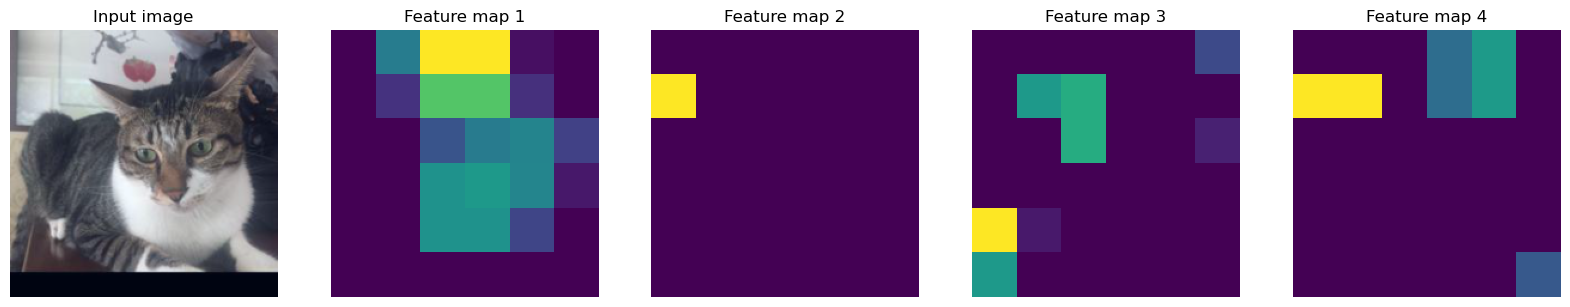

torch.Size([1, 256, 6, 6])


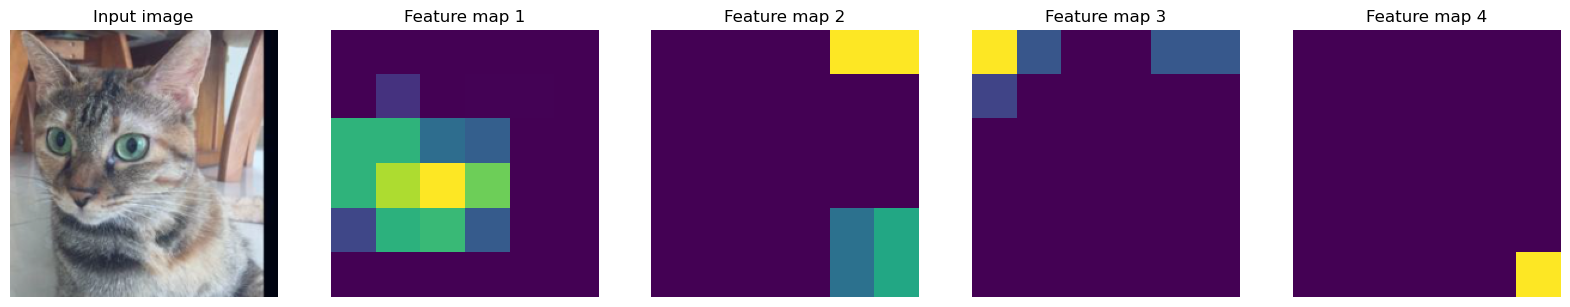

torch.Size([1, 256, 6, 6])


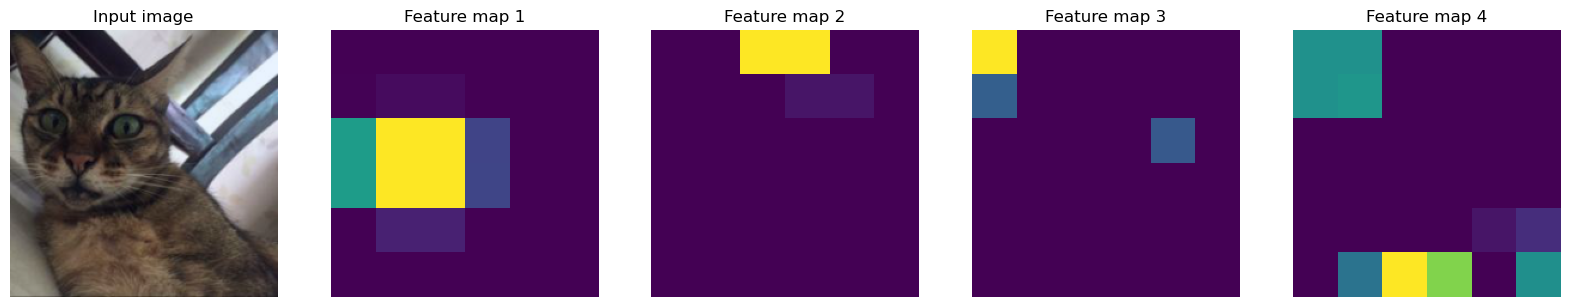

torch.Size([1, 256, 6, 6])


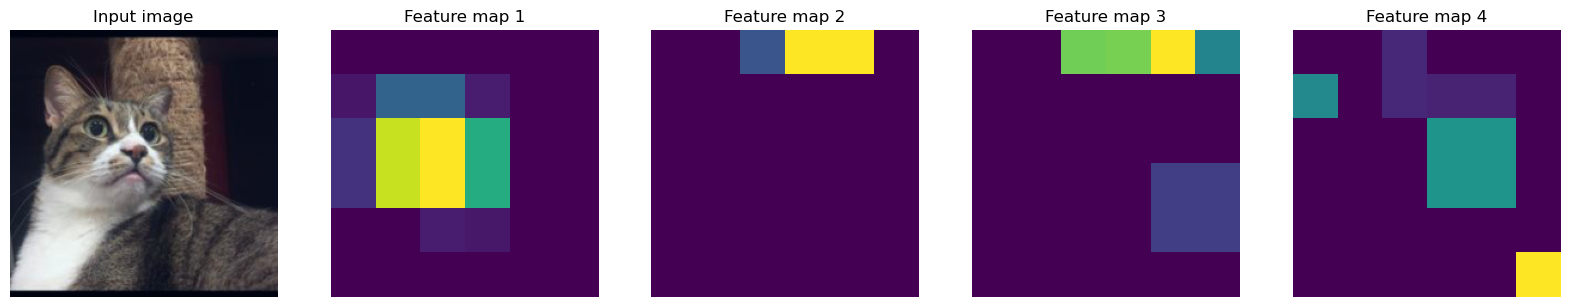

torch.Size([1, 256, 6, 6])


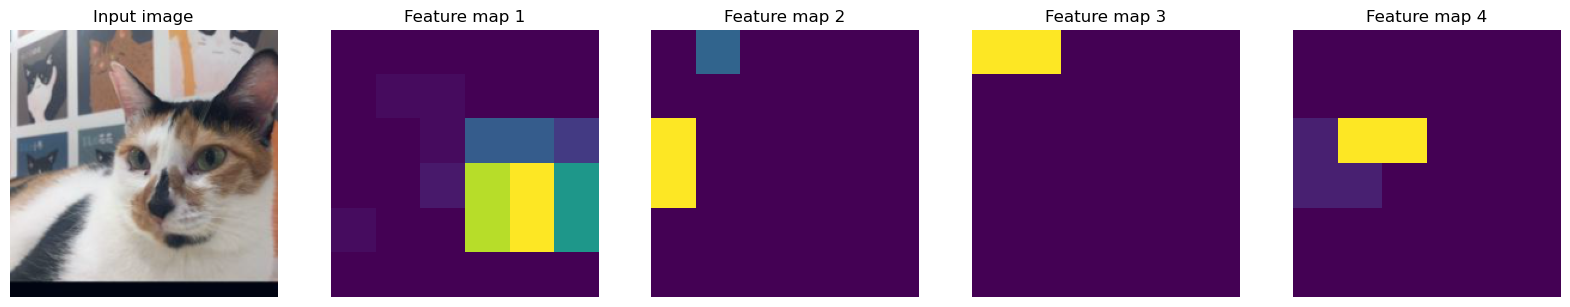

torch.Size([1, 256, 6, 6])


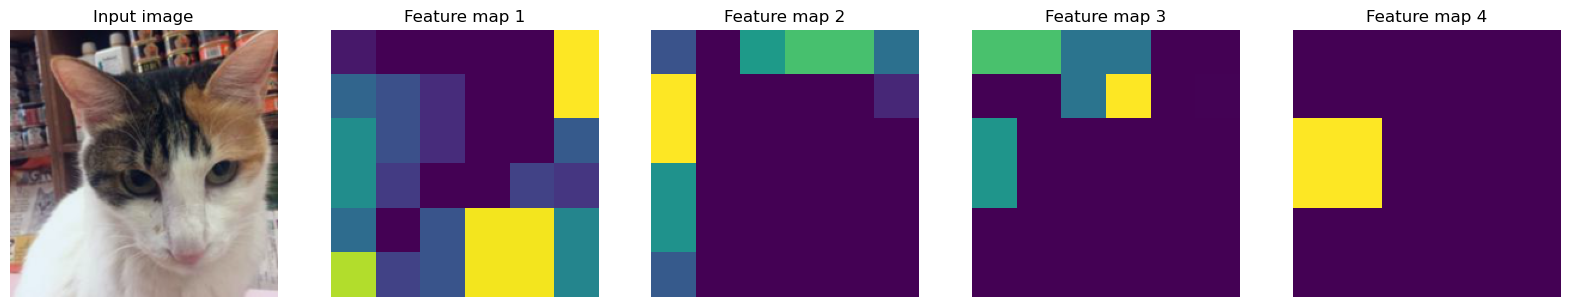

torch.Size([1, 256, 6, 6])


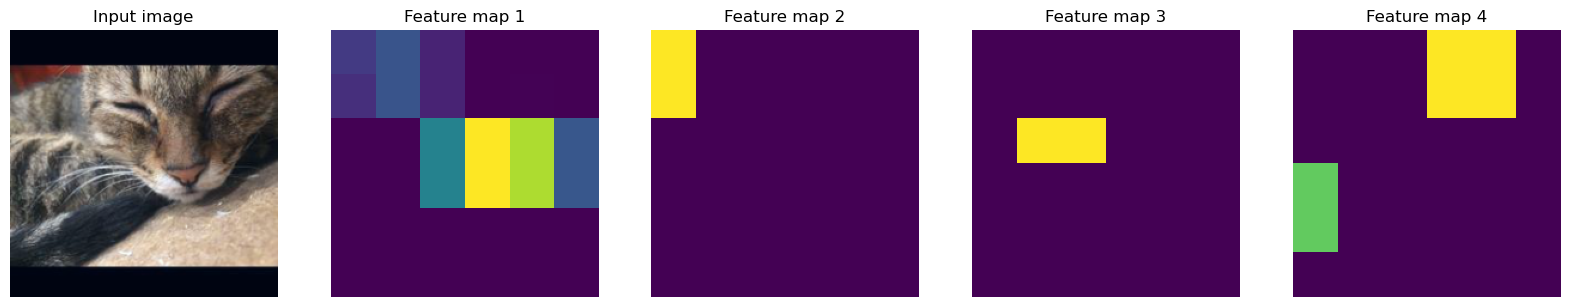

torch.Size([1, 256, 6, 6])


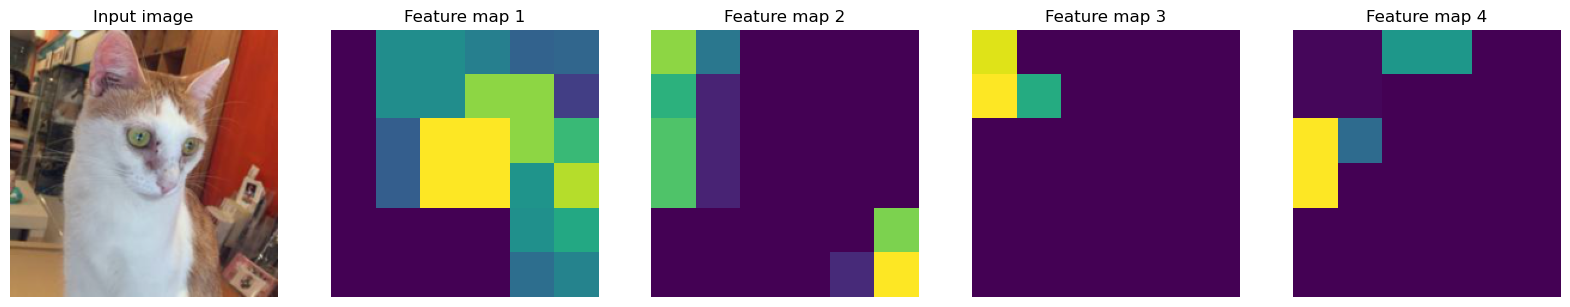

torch.Size([1, 256, 6, 6])


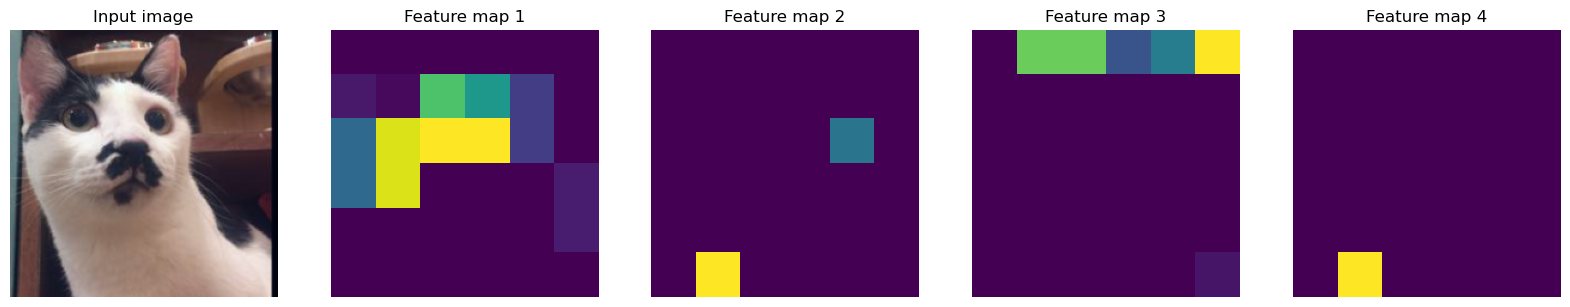

torch.Size([1, 256, 6, 6])


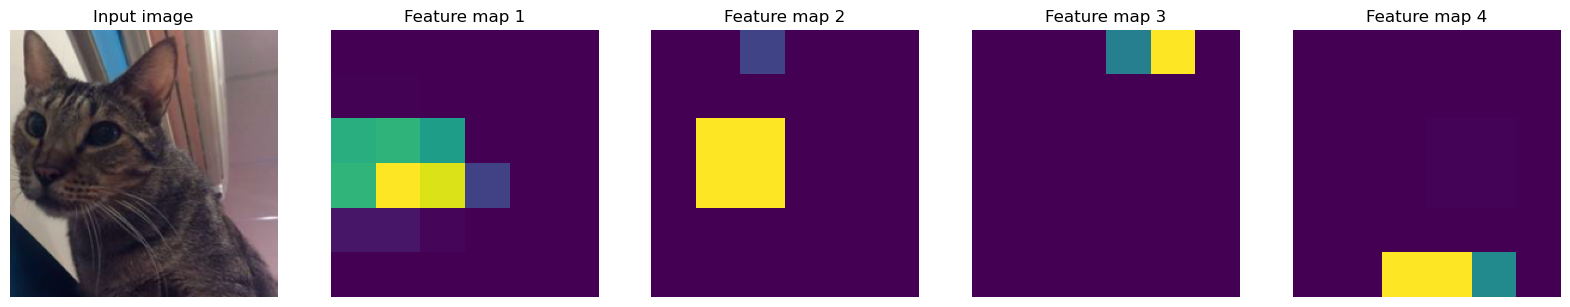

torch.Size([1, 256, 6, 6])


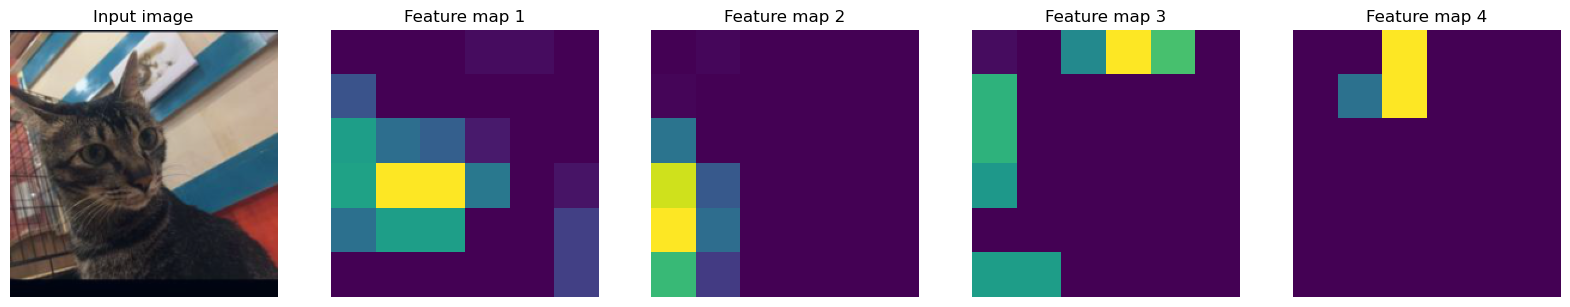

torch.Size([1, 256, 6, 6])


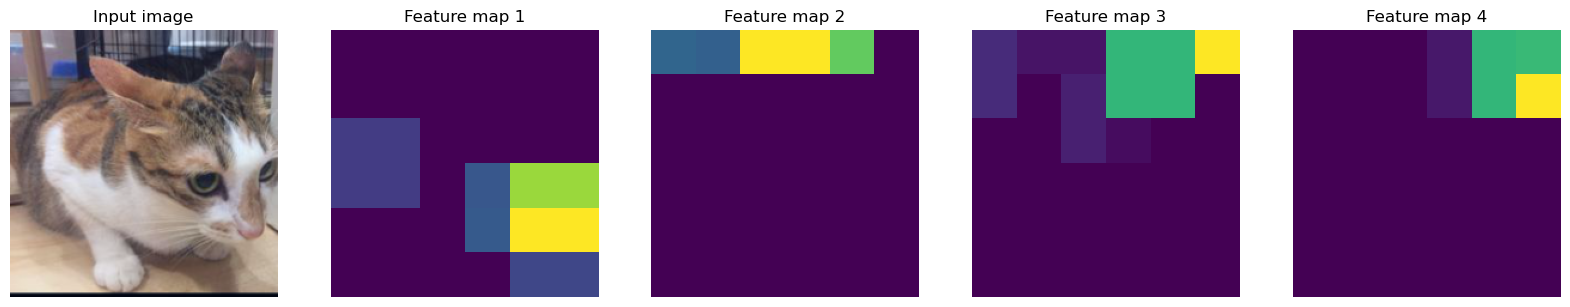

torch.Size([1, 256, 6, 6])


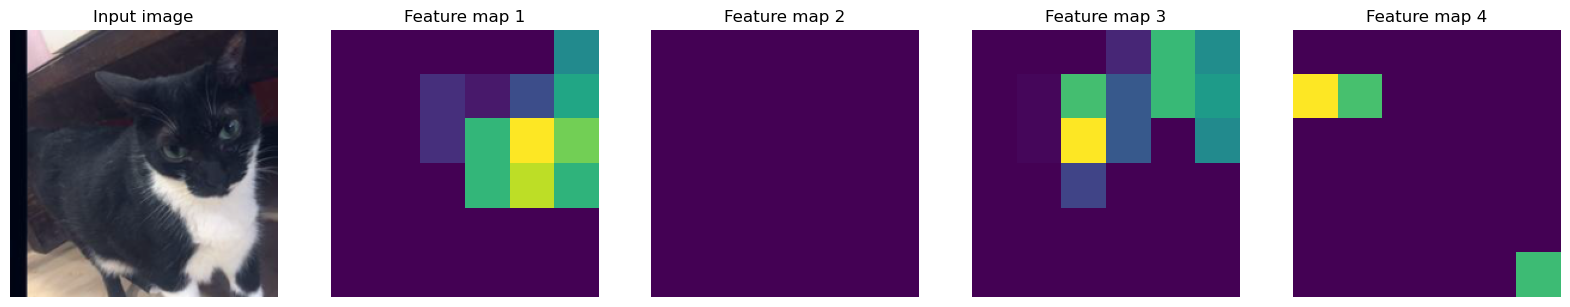

torch.Size([1, 256, 6, 6])


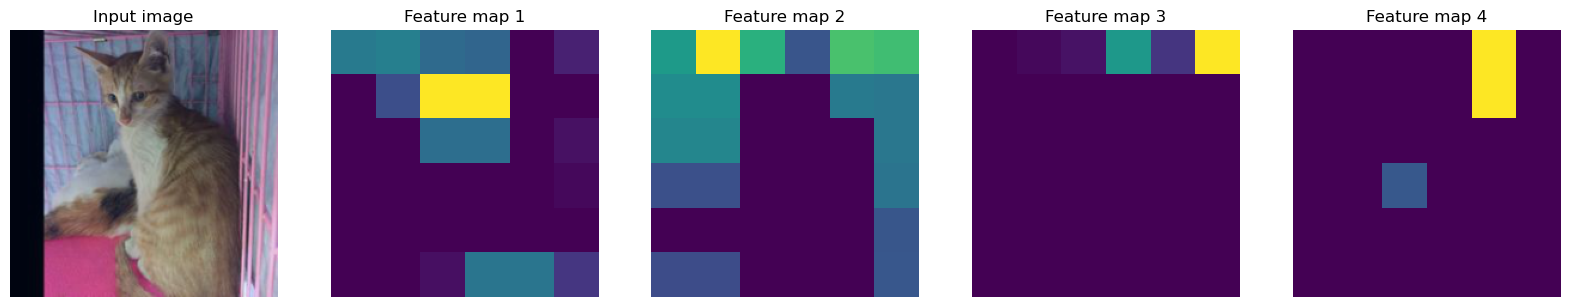

torch.Size([1, 256, 6, 6])


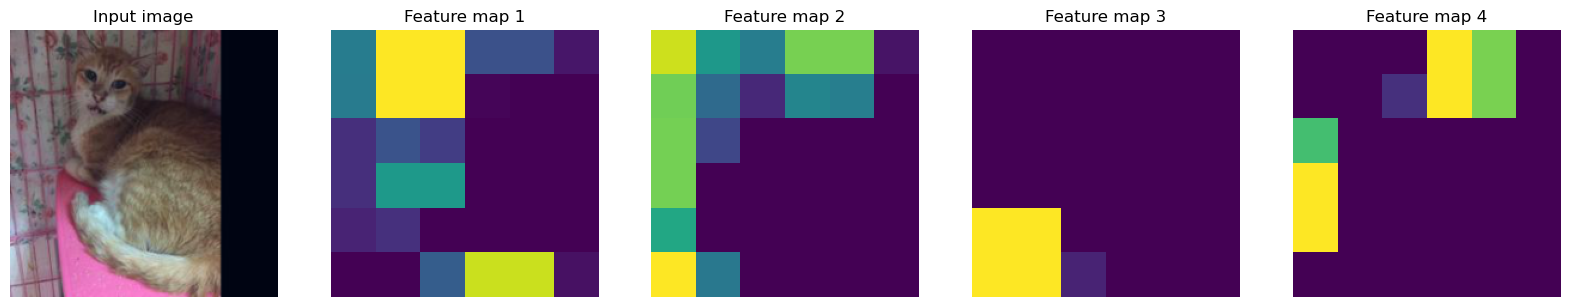

torch.Size([1, 256, 6, 6])


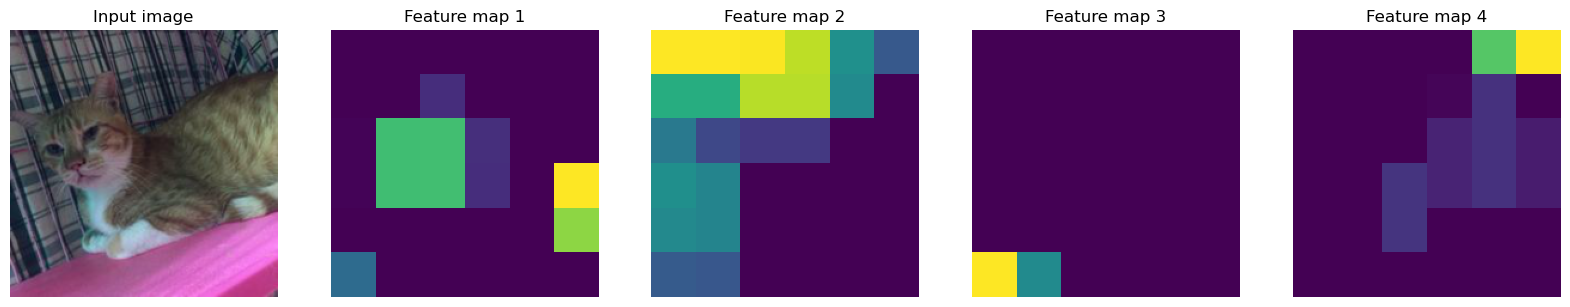

torch.Size([1, 256, 6, 6])


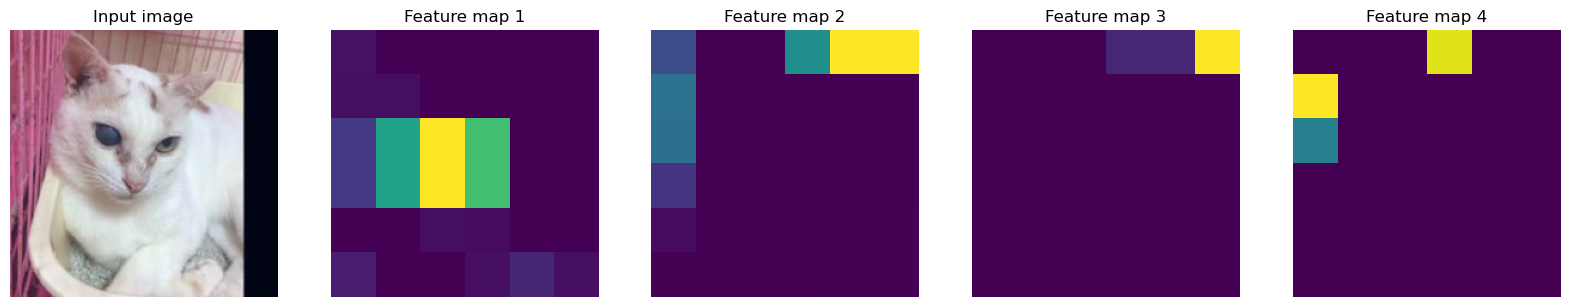

torch.Size([1, 256, 6, 6])


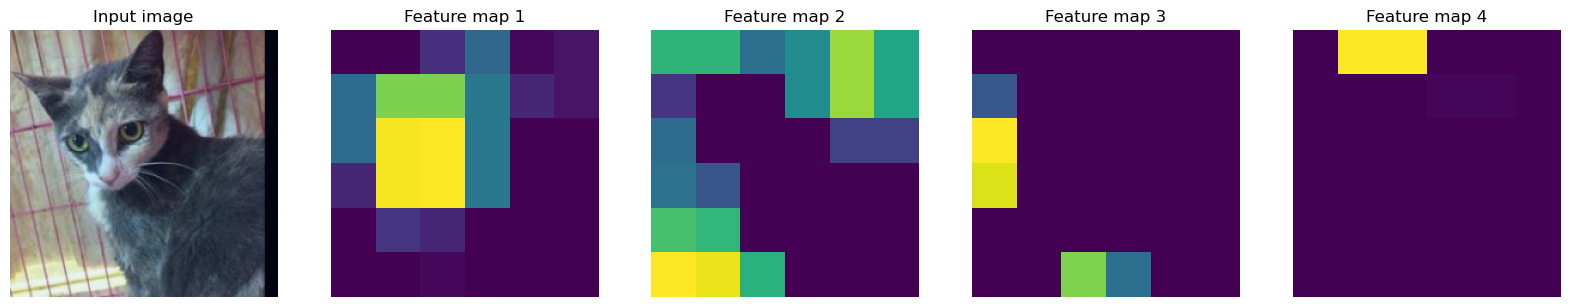

torch.Size([1, 256, 6, 6])


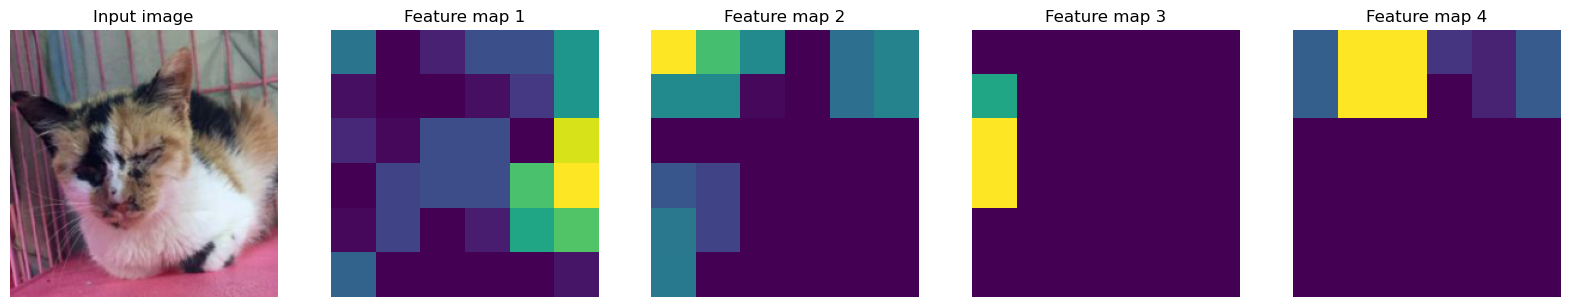

torch.Size([1, 256, 6, 6])


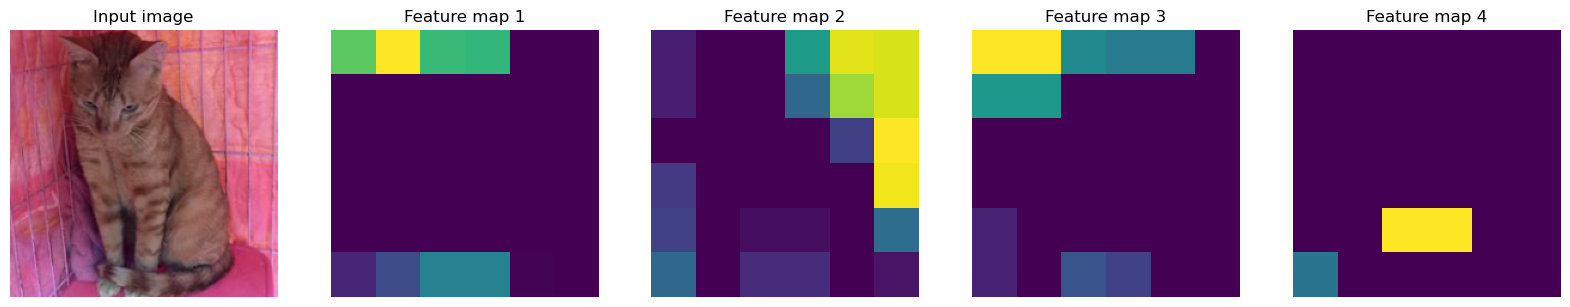

torch.Size([1, 256, 6, 6])


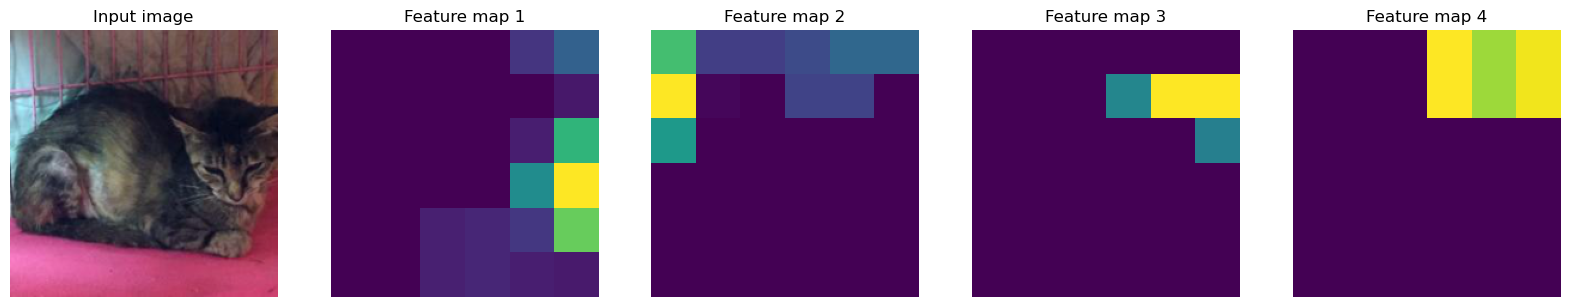

torch.Size([1, 256, 6, 6])


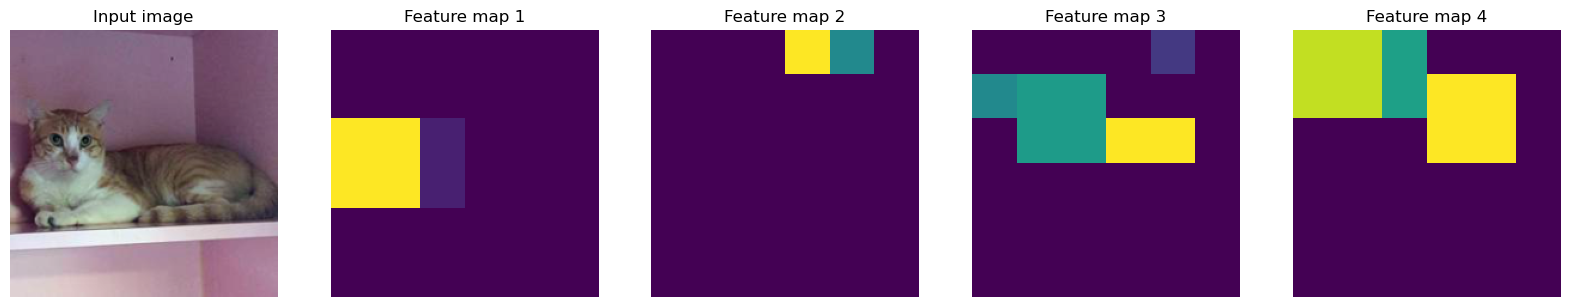

torch.Size([1, 256, 6, 6])


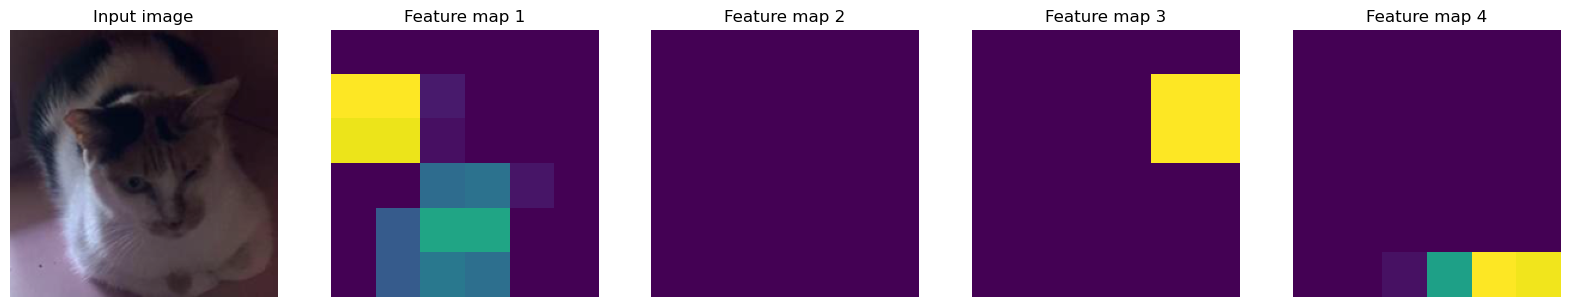

torch.Size([1, 256, 6, 6])


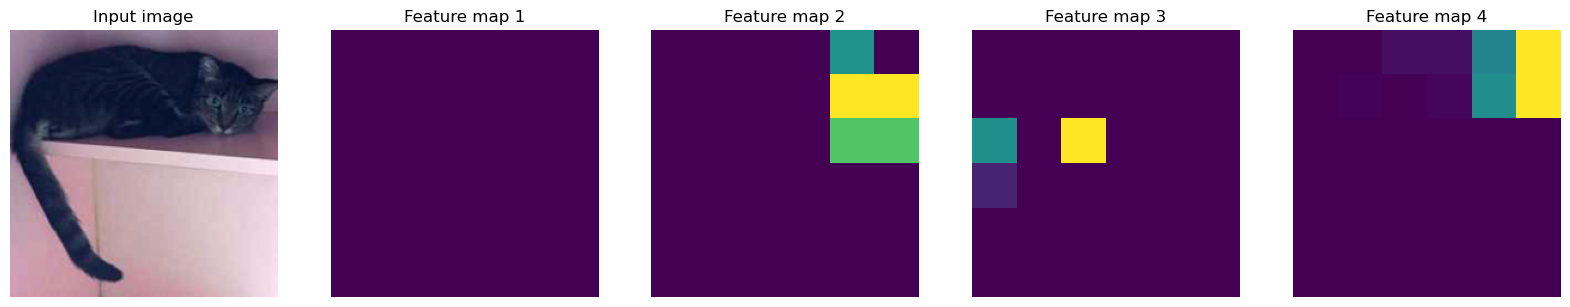

torch.Size([1, 256, 6, 6])


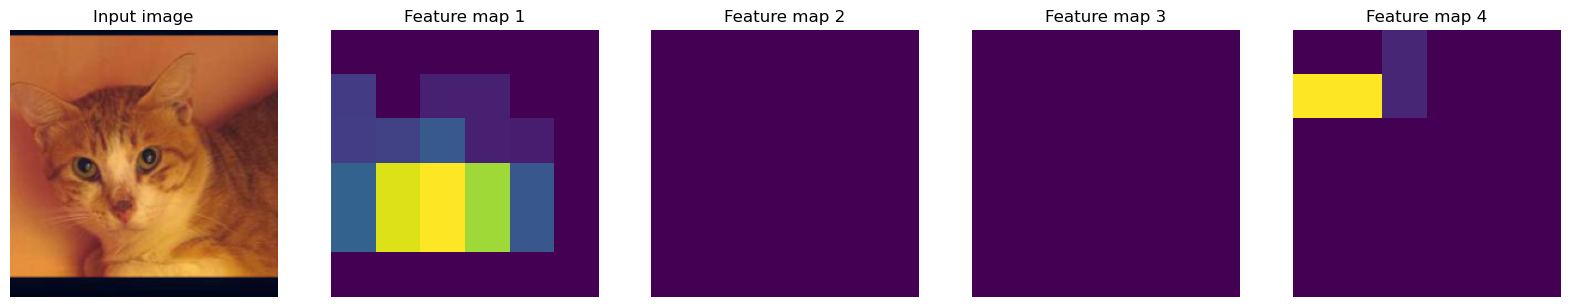

torch.Size([1, 256, 6, 6])


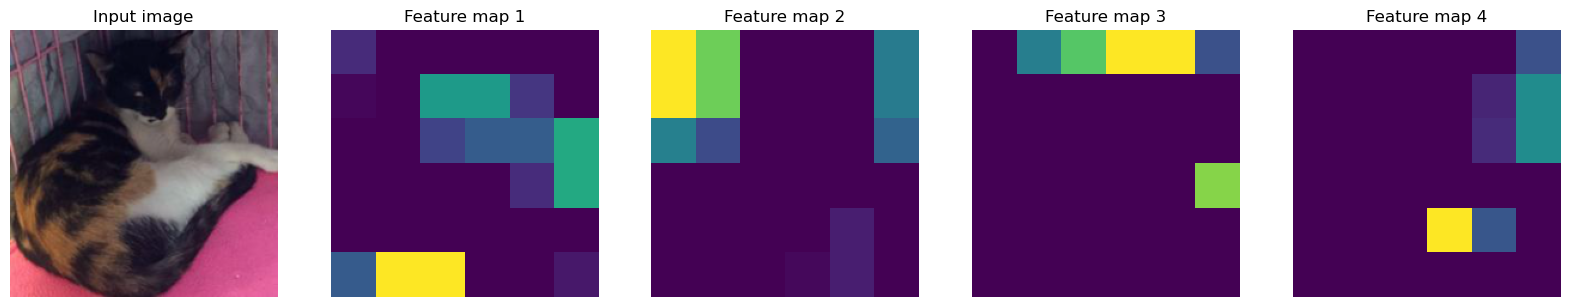

torch.Size([1, 256, 6, 6])


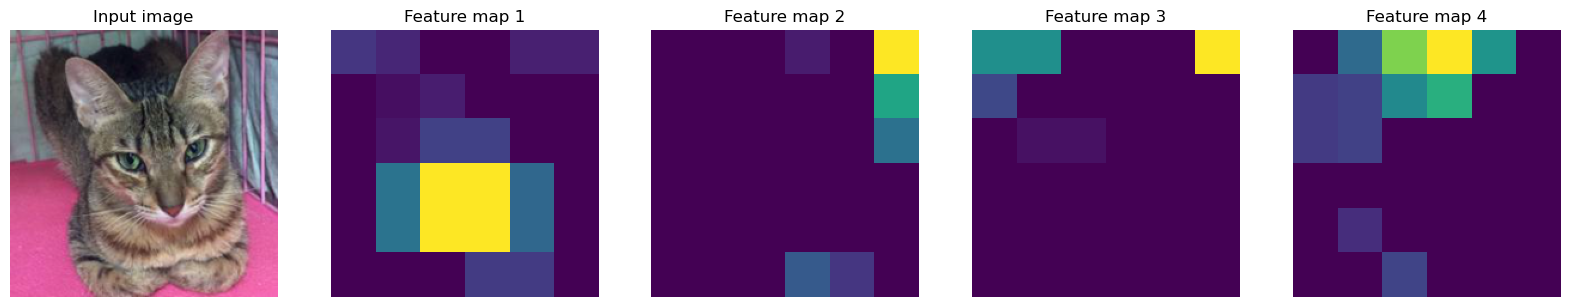

torch.Size([1, 256, 6, 6])


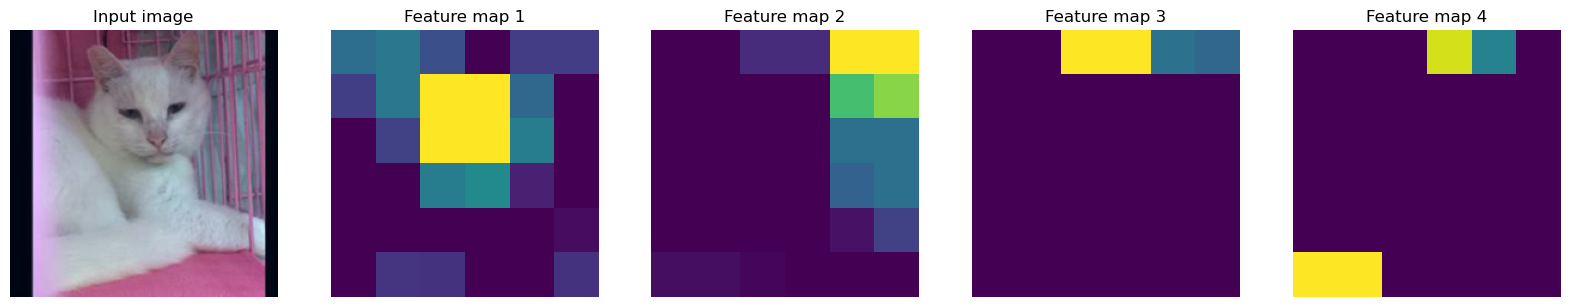

torch.Size([1, 256, 6, 6])


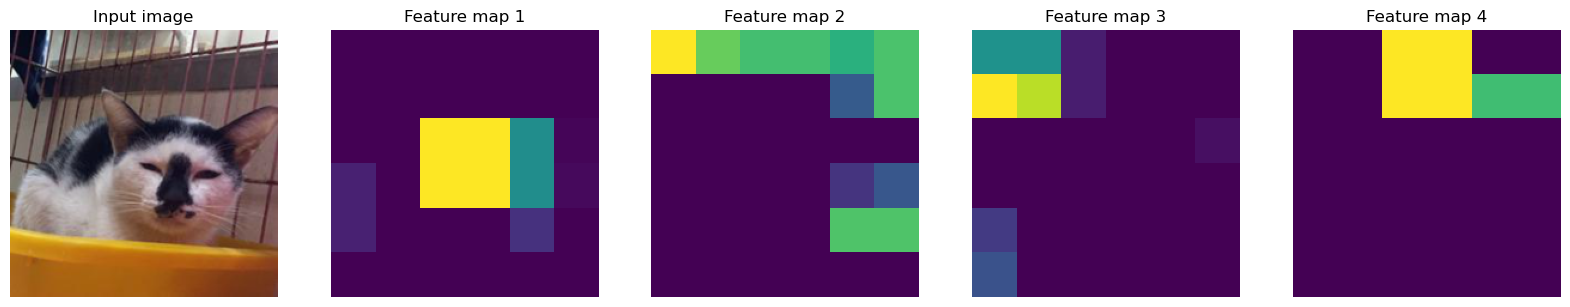

torch.Size([1, 256, 6, 6])


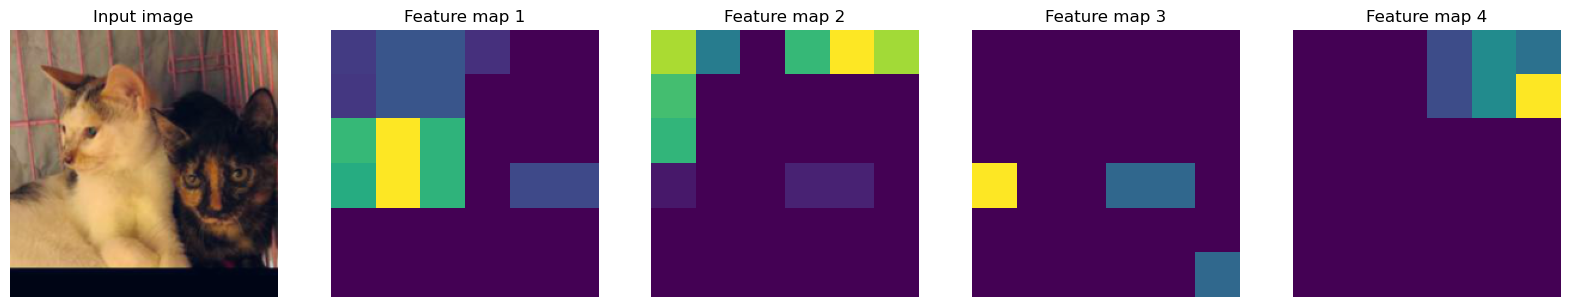

torch.Size([1, 256, 6, 6])


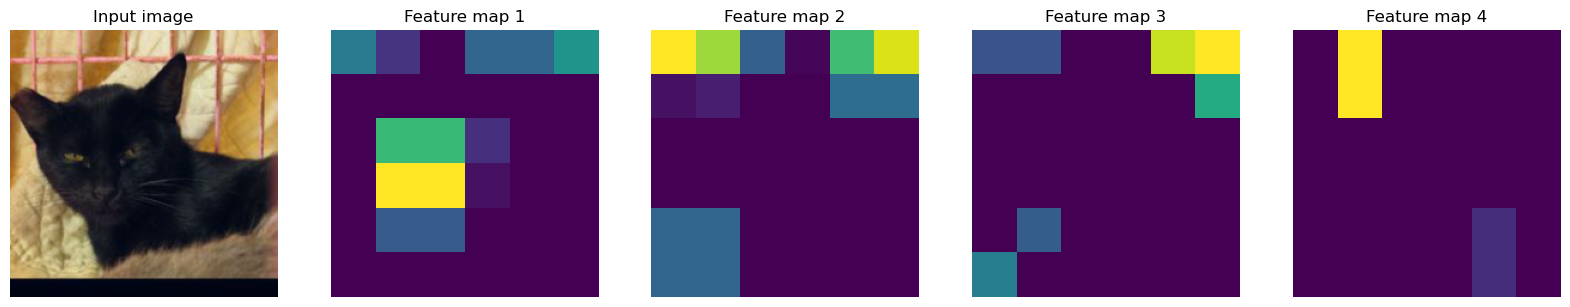

torch.Size([1, 256, 6, 6])


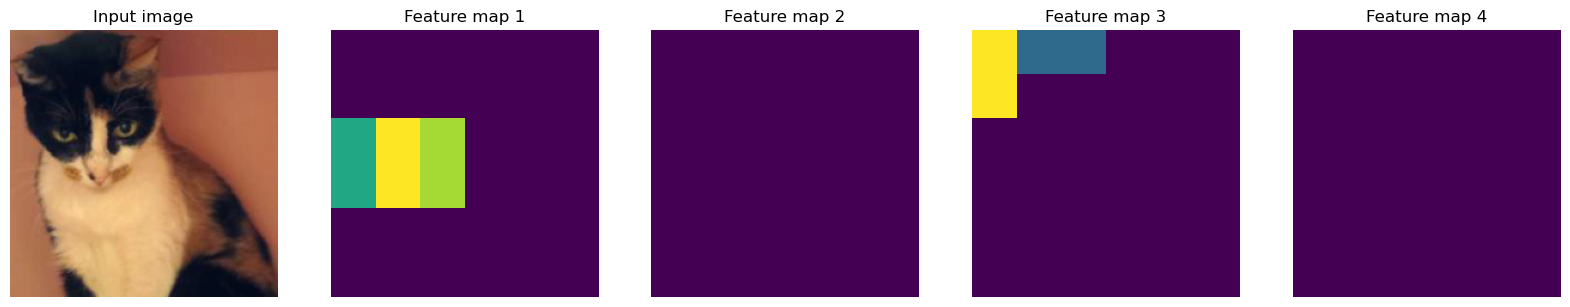

torch.Size([1, 256, 6, 6])


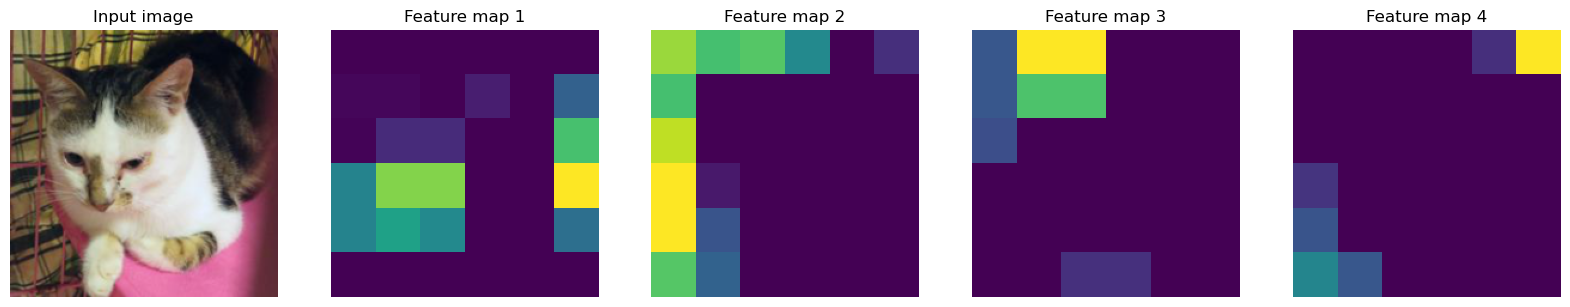

torch.Size([1, 256, 6, 6])


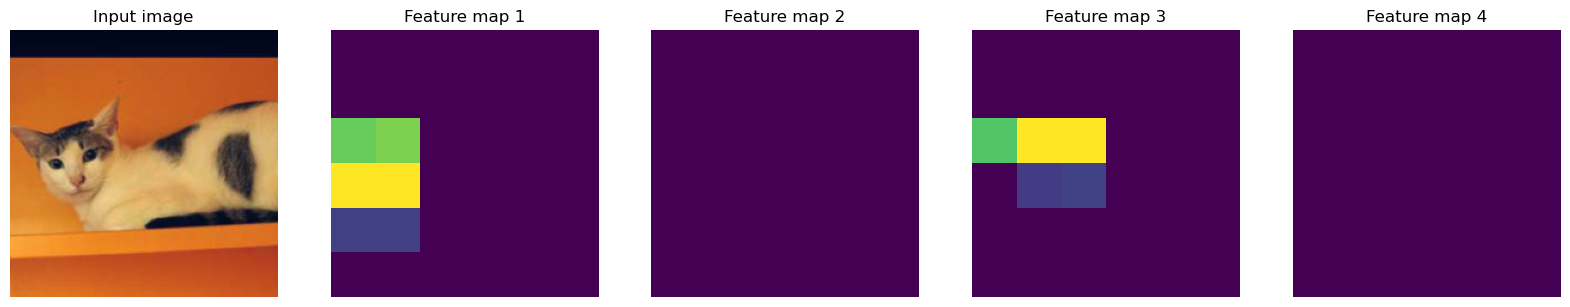

torch.Size([1, 256, 6, 6])


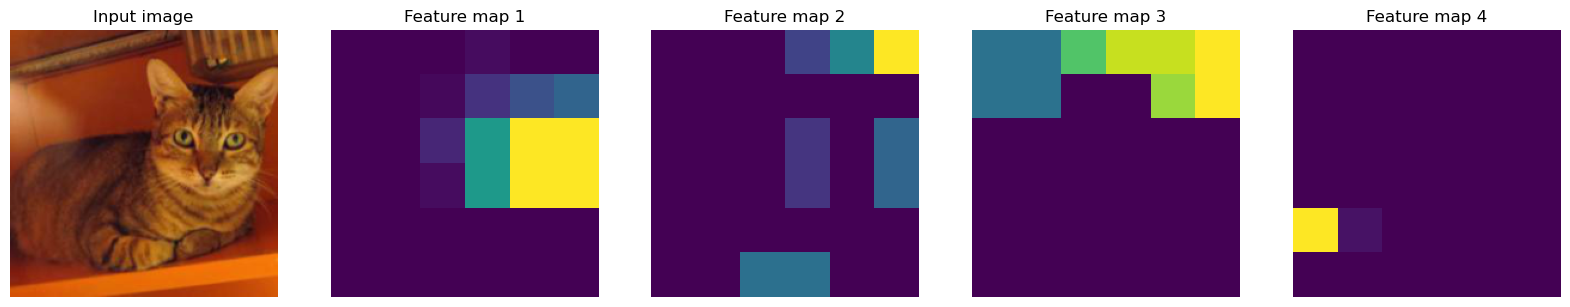

torch.Size([1, 256, 6, 6])


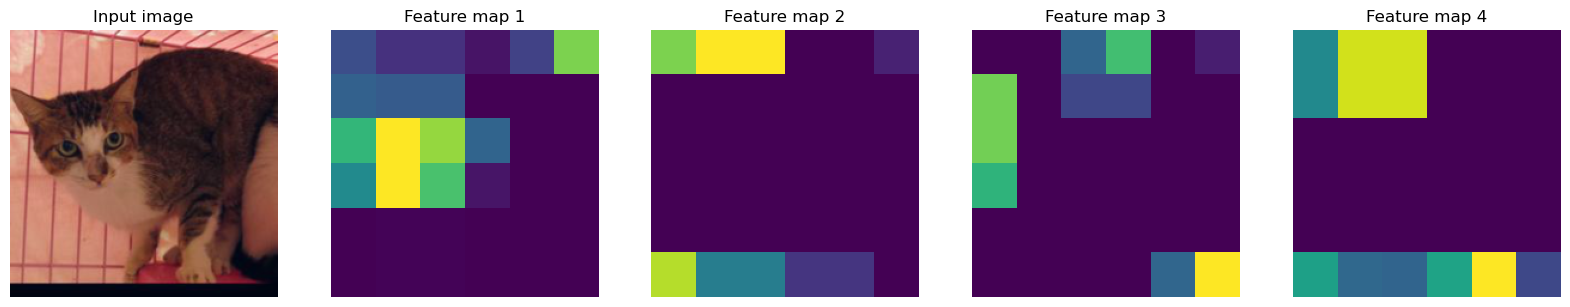

torch.Size([1, 256, 6, 6])


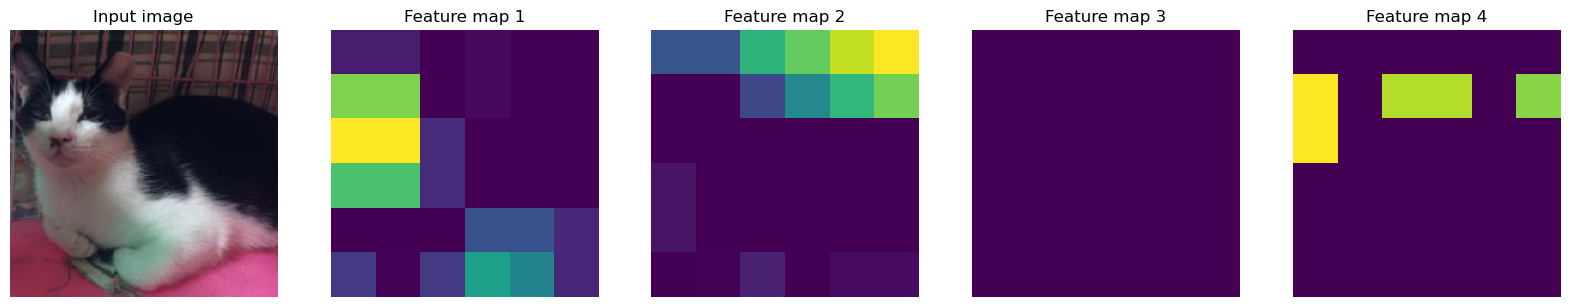

torch.Size([1, 256, 6, 6])


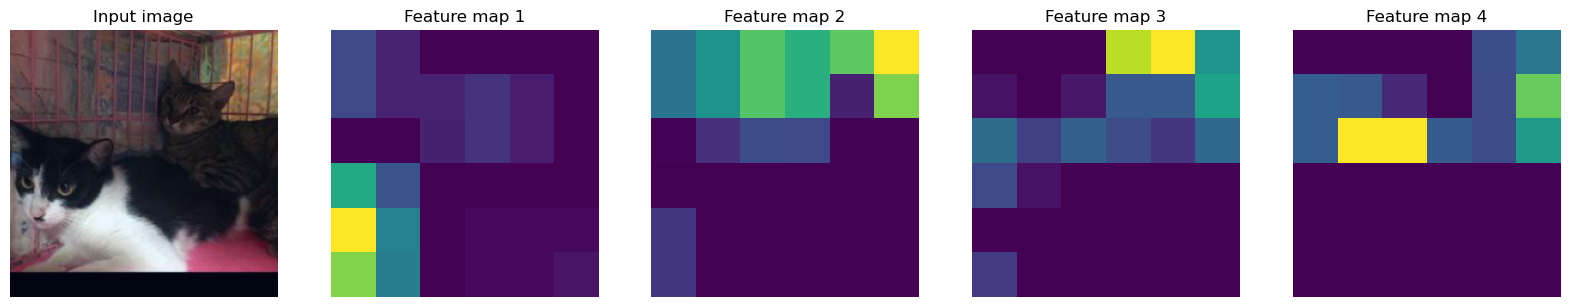

torch.Size([1, 256, 6, 6])


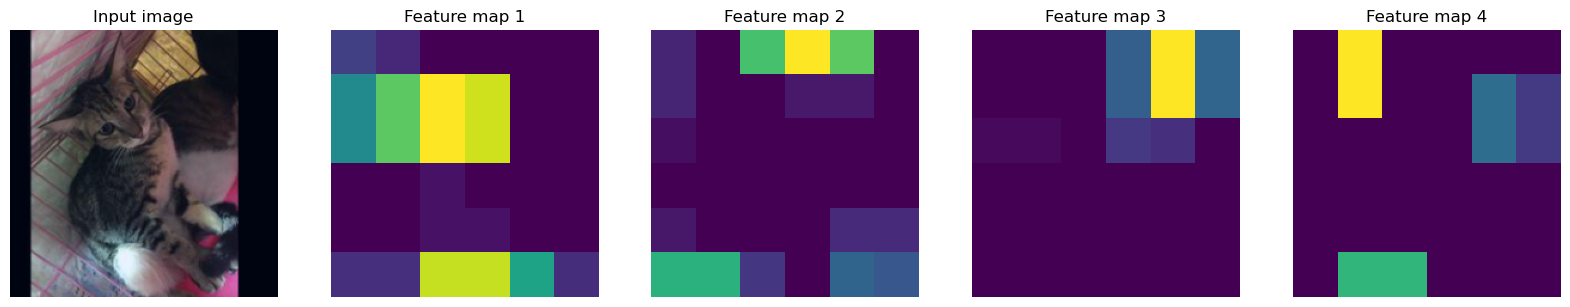

torch.Size([1, 256, 6, 6])


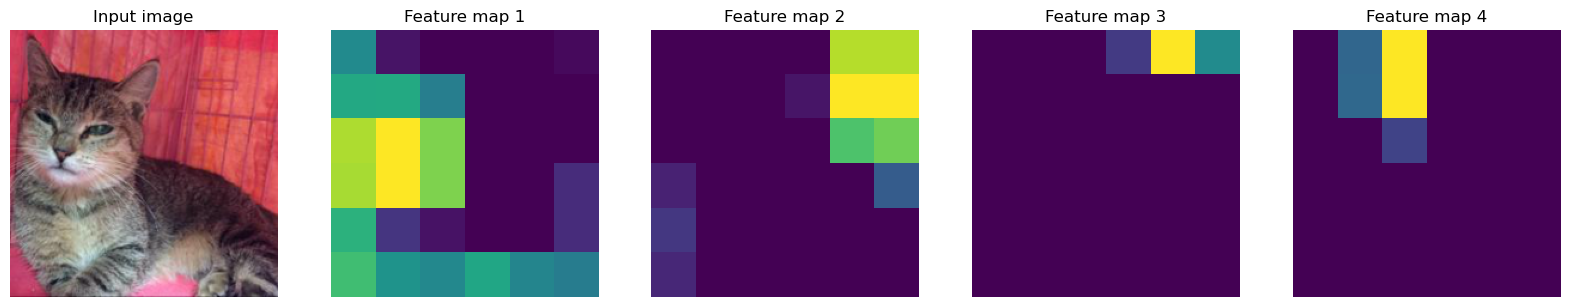

torch.Size([1, 256, 6, 6])


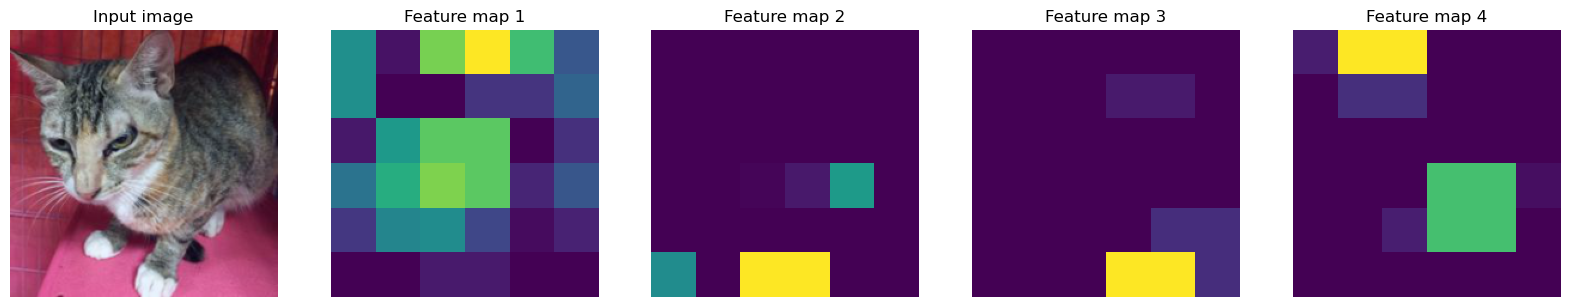

torch.Size([1, 256, 6, 6])


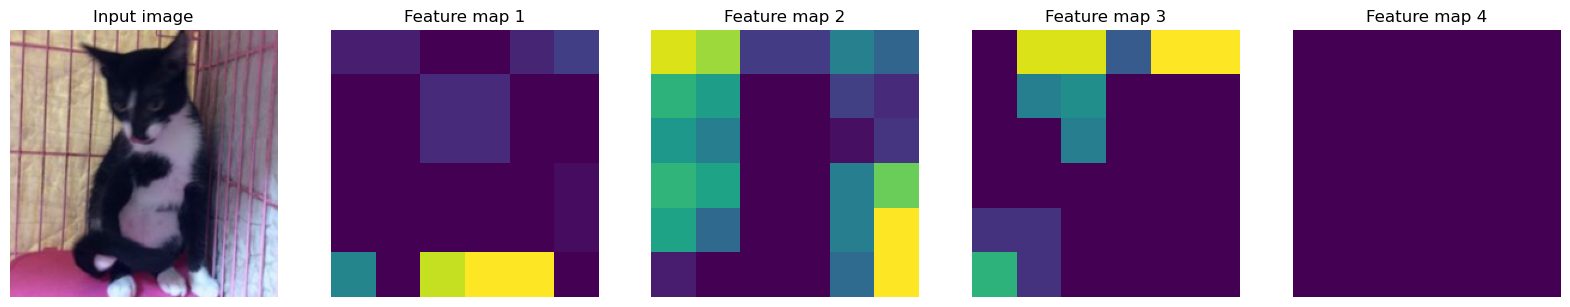

torch.Size([1, 256, 6, 6])


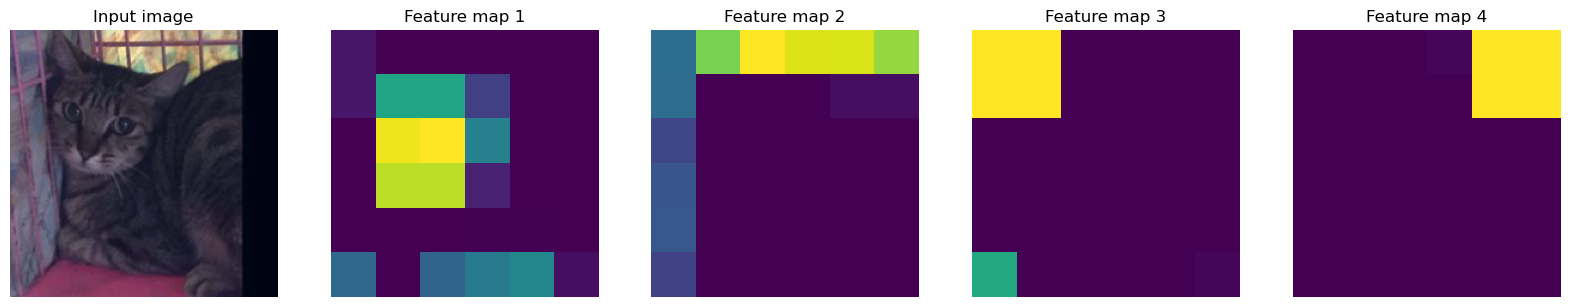

torch.Size([1, 256, 6, 6])


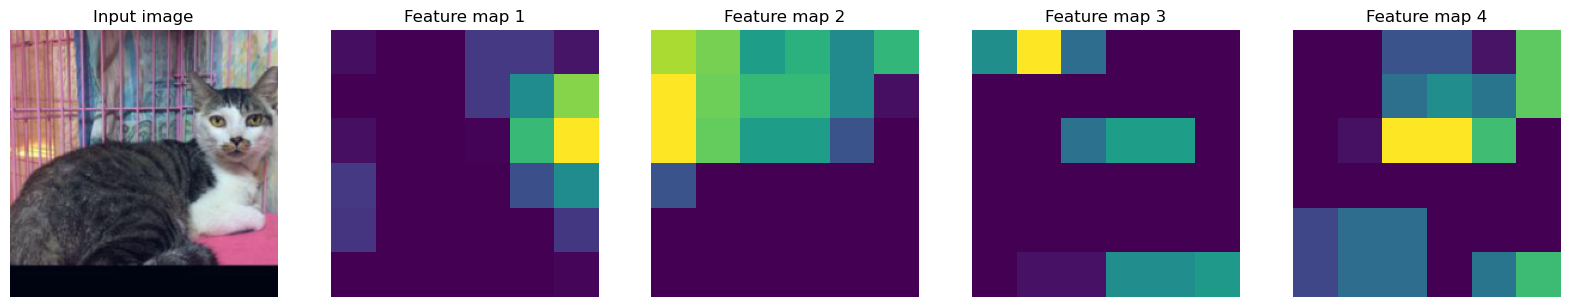

torch.Size([1, 256, 6, 6])


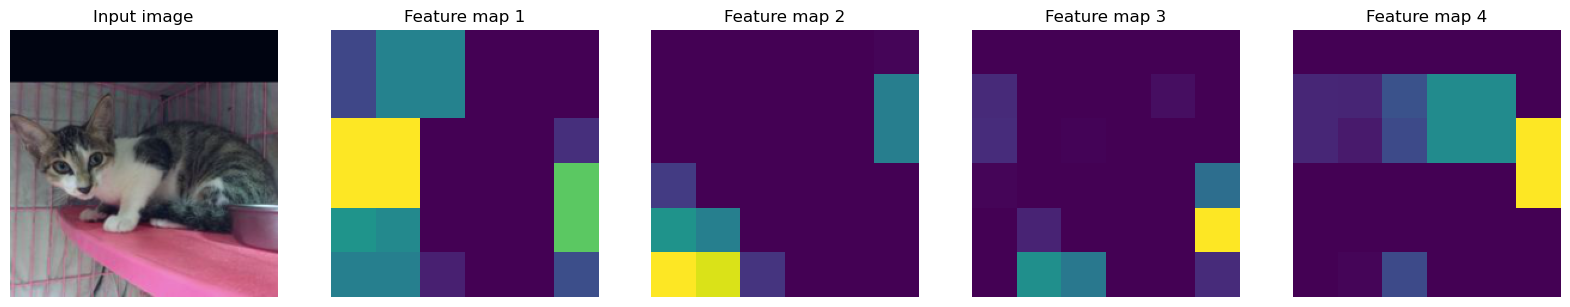

torch.Size([1, 256, 6, 6])


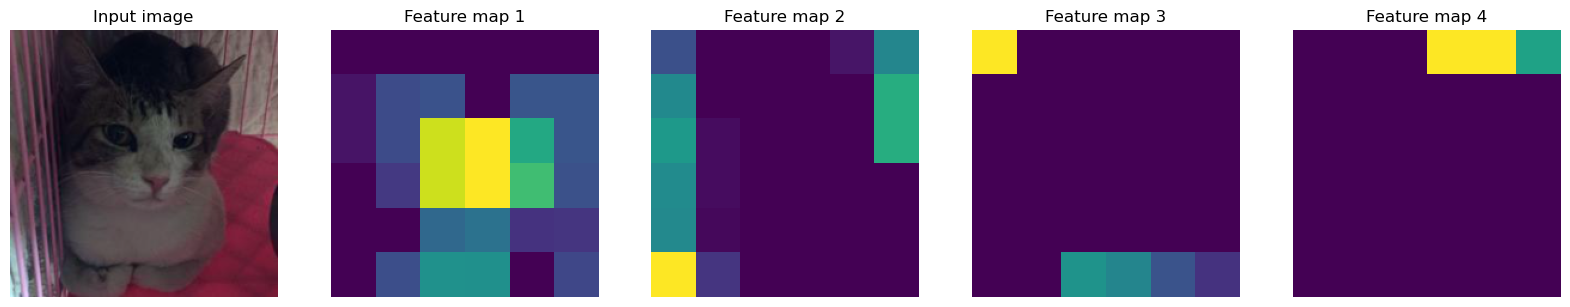

torch.Size([1, 256, 6, 6])


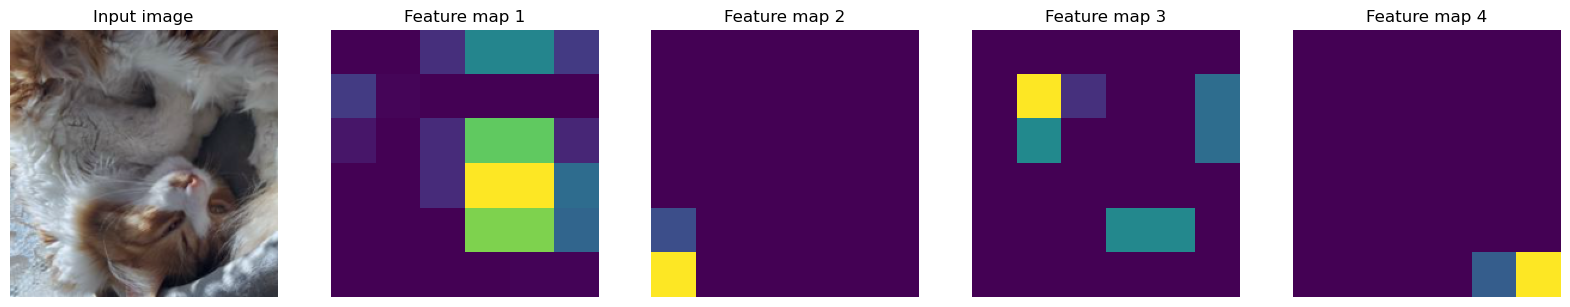

torch.Size([1, 256, 6, 6])


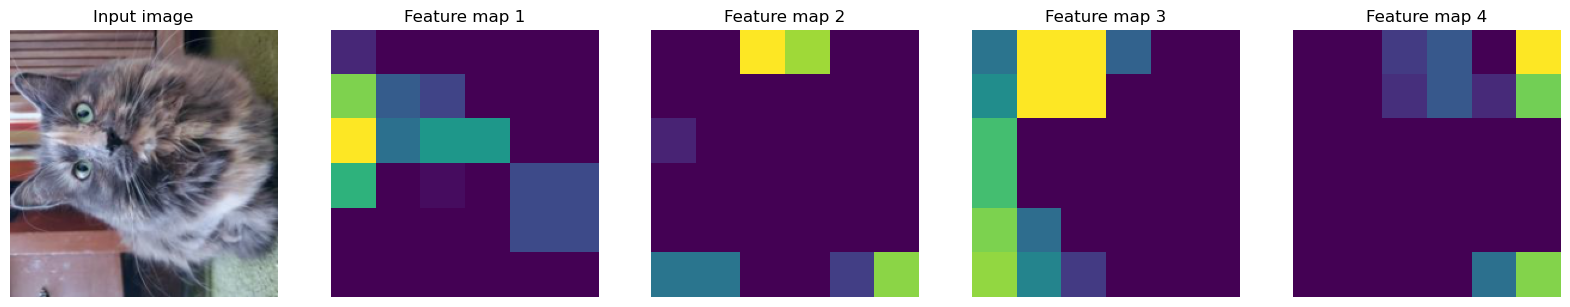

In [105]:
# Pass an image through the model and extract features from a specific layer
for i in range(len(test_images)):
    input_image = test_images[i].unsqueeze(0)
    features = model.features(input_image)
    print(features.shape)

    # Visualize the input image
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 5, 1)
    # normalize image tensor values to range [0, 1] for visualization
    input_image = input_image.squeeze(0).detach().numpy()
    input_image = input_image - np.min(input_image)
    input_image = input_image / np.max(input_image)
    input_image = np.transpose(input_image, (1, 2, 0))
    plt.imshow(input_image)
    plt.title('Input image')
    plt.axis('off')

    # Visualize the feature maps
    for i in range(4):
        plt.subplot(1, 5, i + 2)
        plt.imshow(features[0, i, :, :].detach().numpy())
        plt.title('Feature map ' + str(i + 1))
        plt.axis('off')

    plt.show()

In [ ]:

fig, ax = plt.subplots(1, 5, figsize=(15, 13))

# plot the first layer of the model
for name, param in model.named_parameters():
    if name == 'model.features.0.weight':
        print(name, param.shape)
        ax[0].imshow(param[0,0,:,:].detach().numpy(), cmap='gray')
        ax[0].set_title('First layer')

# plot the second layer of the model
for name, param in model.named_parameters():
    if name == 'model.features.3.weight':
        print(name, param.shape)
        ax[1].imshow(param[0,0,:,:].detach().numpy(), cmap='gray')
        ax[1].set_title('Second layer')

# plot the third layer of the model
for name, param in model.named_parameters():
    if name == 'model.features.6.weight':
        print(name, param.shape)
        ax[2].imshow(param[0,0,:,:].detach().numpy(), cmap='gray')
        ax[2].set_title('Third layer')

# plot the fourth layer of the model
for name, param in model.named_parameters():
    if name == 'model.features.8.weight':
        print(name, param.shape)
        ax[3].imshow(param[0,0,:,:].detach().numpy(), cmap='gray')
        ax[3].set_title('Fourth layer')

# plot the fifth layer of the model
for name, param in model.named_parameters():
    if name == 'model.features.10.weight':
        print(name, param.shape)
        ax[4].imshow(param[0,0,:,:].detach().numpy(), cmap='gray')  
        ax[4].set_title('Fifth layer')   

In [40]:
from IPython import display
import pandas as pd

results = {'index':[], 'prediction':[], 'probability (%)':[], 'truth':[]}

for index in range(len(val_images)):
    with torch.no_grad():
        images = val_images[index]
        labels = val_labels[index]

        images = images.unsqueeze(0)
        outputs = model(images)

        sig_output = F.sigmoid(outputs).squeeze(0)

        _, predicted = torch.max(outputs.data, 1)

        # add result in pandas dataframe
        results['index'].append(index)
        results['prediction'].append(predicted.item())
        results['probability (%)'].append(round(sig_output[predicted.item()].item()*100, 2))
        results['truth'].append(labels[predicted.item()].item()) 

        
# display dataframe
df = pd.DataFrame(results)
display.display(df)

index  prediction  probability (%)  truth
0       0           0             9.85    1.0
1       1           1             8.20    1.0
2       2           2            68.44    1.0
3       3           3            27.45    1.0
4       4           4             1.81    1.0
5       5           5            36.19    1.0
6       6           6            74.24    1.0
7       7           7             2.08    1.0
8       8           8            27.58    1.0
9       9           9            14.50    1.0
10     10          10             4.12    1.0
11     11          11            73.57    1.0
12     12          12             0.07    1.0
13     13          13             9.39    1.0
14     14          14            28.79    1.0
15     15          15            39.71    1.0
16     16          16            46.71    1.0
17     17          17             2.33    1.0
18     18          18            30.53    1.0
19     19          19            58.32    1.0
20     20          20             0.29    1.0
21     21          24            33.45    0.0
22     22          22            48.79    1.0
23     23          23            93.61    1.0
24     24          24            40.30    1.0
25     25          25             1.52    1.0
26     26          26            21.82    1.0
27     27          27            34.45    1.0
28     28          28             4.58    1.0
29     29          29             1.04    1.0
30     30          30            61.24    1.0
31     31          31             2.79    1.0
32     32          32            29.51    1.0
33     33          33            33.84    1.0
34     34          34            17.38    1.0
35     35          35            38.52    1.0
36     36          36            13.94    1.0
37     37          37             9.01    1.0
38     38          38             7.58    1.0
39     39          39            61.14    1.0
40     40          40             1.45    1.0
41     41          41             1.61    1.0
42     42          39             0.44    0.0
43     43          43            29.35    1.0
44     44          44            66.93    1.0
45     45          45            47.35    1.0
46     46          11             0.04    0.0
47     47          47             2.64    1.0